In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import math
import torch
import torchvision
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import lbg_forecast.cosmology as cos
import lbg_forecast.priors_gp_csfrd as gp
from uncertainties import unumpy as upy

In [2]:
def inverse(x):
    return x**2
def forward(x):
    return np.sqrt(x)

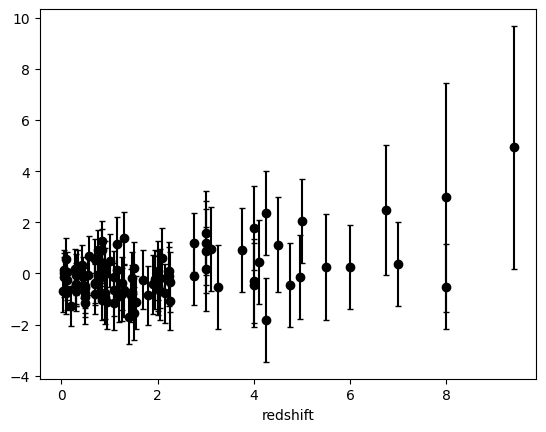

In [3]:
data = ascii.read("csfr_data/csfrs.dat")
scale = np.array(data["Scale"])
redshift = cos.scale_to_z(scale)
total_obs_csfr = np.array(data["Total_Obs_CSFR"])
true_csfr = np.array(data["True_CSFR"])

train_x, train_y, train_yerrs, csfrd_mean, csfrd_std, train_log_csfrd, train_log_csfrd_errors = gp.get_training_data("./", True)

In [4]:
model, likelihood = gp.create_gp_model(train_x, train_y, train_yerrs, [1.0, 999], [-999, 999])
trained_model, trained_likelihood = gp.gp_training_loop(model, likelihood, train_x, train_y, training_iter=1000, lr=0.1)


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
5.93561526562611
4.533951233955558
3.3445879471423448
2.408735215428701
1.761236362832682
1.4194054014736335
1.3542136532295028
1.3529586742548876
1.3517569696473435
1.3506015410316732
1.3494914701375083
1.3484280515544682
1.3474129849731018
1.346447629199654
1.345532769363255
1.3446686120119276
1.34385486713025
1.343090851445378
1.3423755850908283
1.3417078717565565
1.341086360625362
1.34050959176897
1.3399760278212534
1.3394840749142145
1.339032095641071
1.3386184164593817
1.3382413315708657
1.3378991049505364
1.3375899718556925
1.3373121408260145
1.3370637968890238
1.3368431064114443
1.3366482237893649
1.3364772999528387
1.3363284924786396
1.336199976962788
1.3360899592055766
1.3359966877071248
1.3359184659596552
1.3358536640493934
1.3358007291396519
1.335758194488899
1.3357246867541064
1.3356989314312144
1.3356797563829093
1.3356660934923479


In [5]:
test_redshift = torch.linspace(0.001, 10, 200)
f_preds = gp.gp_evaluate_model(trained_model, test_redshift)

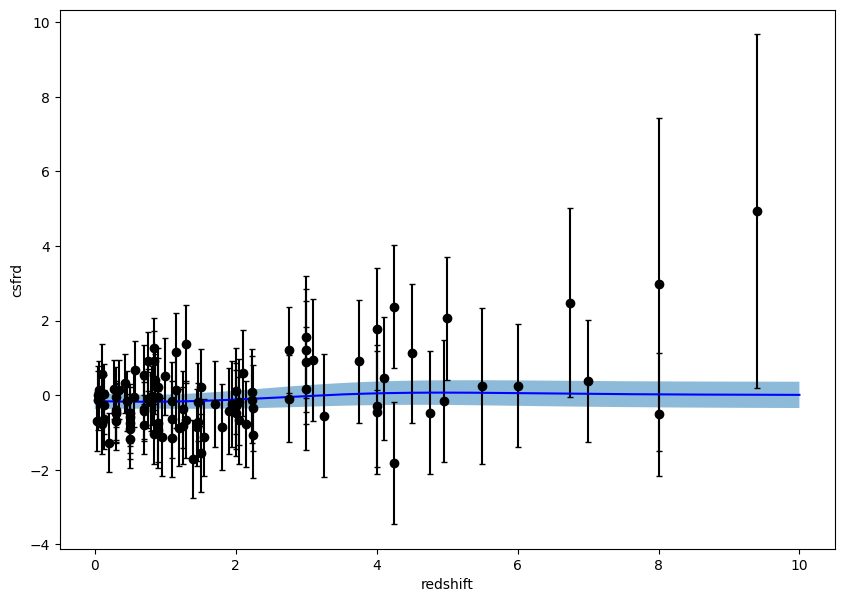

In [6]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    #shift = gp.mean_obs_behroozi(test_redshift.numpy(), log=True, path='./')
    #ax.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000)
    #ax.errorbar(redshift, np.log10(true_csfr), zorder=1000)

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x.numpy(), train_y.numpy(), yerr=train_yerrs, fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_redshift.numpy(), f_preds.mean, c='b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_redshift.numpy(), lower, upper, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    #ax.set_ylim(-2.7, -0.5)
    #ax.set_xlim(-0.0, 10)
    #ax.set_xscale('function', functions=(forward, inverse))

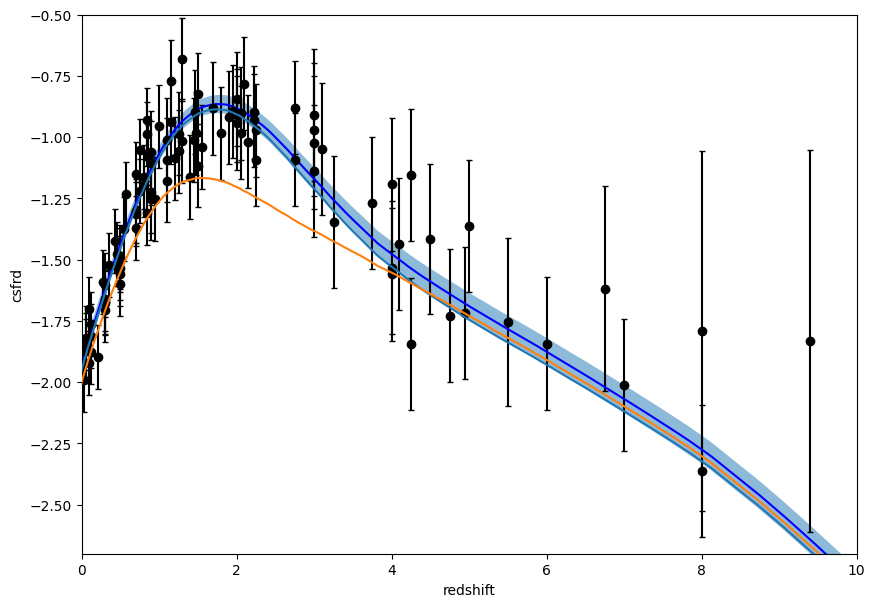

In [7]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    shift = gp.mean_obs_behroozi(test_redshift.numpy(), log=True, path='./')
    ax.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000)
    ax.errorbar(redshift, np.log10(true_csfr), zorder=1000)

    pred_std = 2*f_preds.stddev.numpy()
    pred_mean = f_preds.mean.numpy()
    preds_upy = upy.uarray(pred_mean, pred_std)
    preds_transform = preds_upy*csfrd_std + csfrd_mean + shift

    fpreds_mean = upy.nominal_values(preds_transform)
    fpreds_std = upy.std_devs(preds_transform)

    # Plot training data as black stars
    ax.errorbar(train_x.numpy(), train_log_csfrd, yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_redshift.numpy(), fpreds_mean, c='b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_redshift.numpy(), fpreds_mean-fpreds_std, fpreds_mean+fpreds_std, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    #ax.set_xscale('function', functions=(forward, inverse))

/Users/fpetri/venvs/pytorch/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


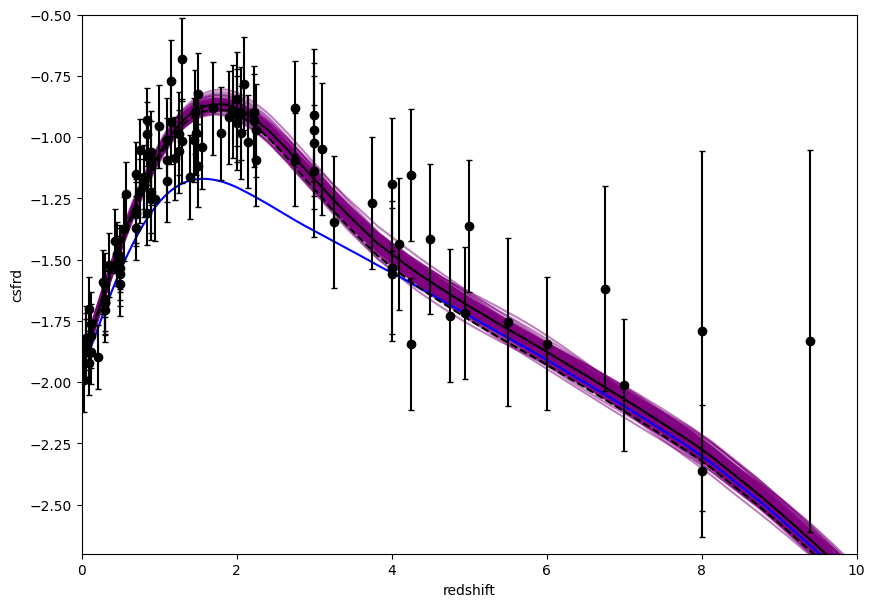

In [8]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 100
    for sample in range(nsamples):
        f_sample = f_preds.sample().numpy()*csfrd_std+csfrd_mean+shift
        #if((f_sample > 0.0).all()):
        ax.plot(test_redshift, f_sample, c='purple', alpha=0.5)
    ax.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000, ls='--', c='k')
    ax.plot(test_redshift, f_preds.mean.numpy()*csfrd_std+csfrd_mean+shift, zorder=1000, ls='-', c='k')
    ax.plot(prospb[:, 0], np.log10(prospb[:, 2]), c='b')
    ax.errorbar(train_x.numpy(), train_log_csfrd, yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    #ax.set_xscale('function', functions=(forward, inverse))

/var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/ipykernel_97549/635526763.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)


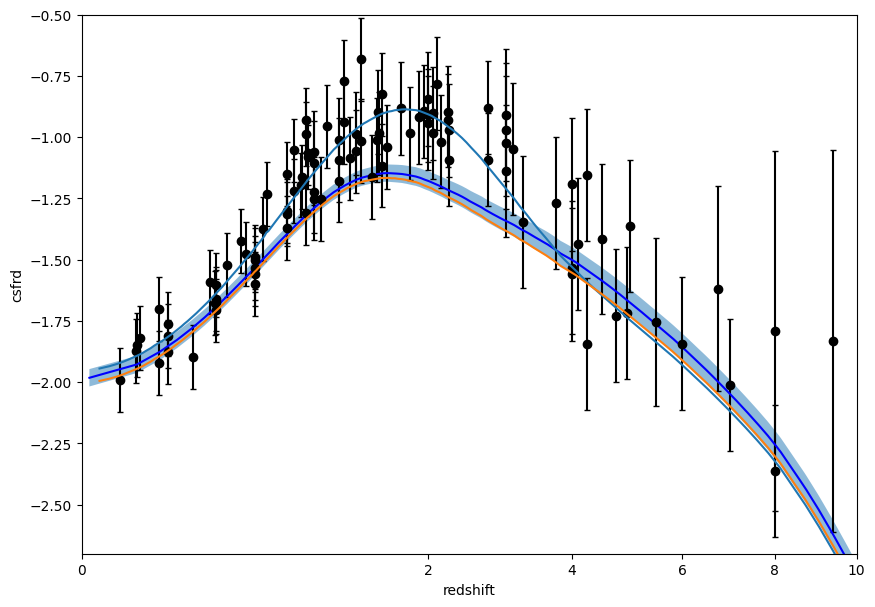

In [9]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
sys_shift = gp.systematic_shift(test_redshift, path='./')
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    preds_transform_shift = preds_transform - sys_shift
    fpreds_shift_mean = upy.nominal_values(preds_transform_shift)
    fpreds_shift_std = upy.std_devs(preds_transform_shift)

    ax.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000)
    ax.errorbar(redshift, np.log10(true_csfr), zorder=1000)

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x.numpy(), train_log_csfrd.numpy(), yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_redshift.numpy(), fpreds_shift_mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_redshift.numpy(), fpreds_shift_mean-fpreds_shift_std, fpreds_shift_mean+fpreds_shift_std, alpha=0.5)

    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    ax.set_xscale('function', functions=(forward, inverse))

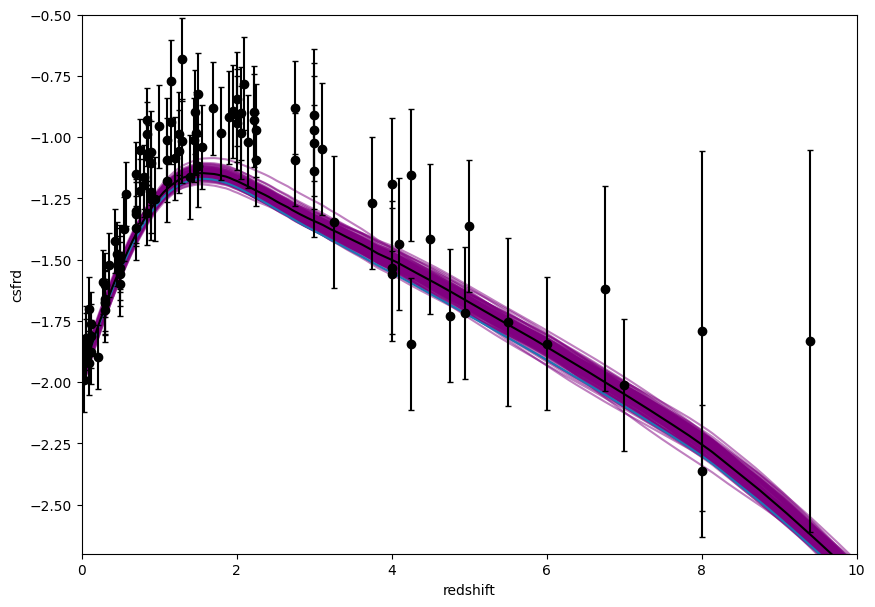

In [10]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 100
    for sample in range(nsamples):
        f_sample = f_preds.sample().numpy()*csfrd_std+csfrd_mean+shift-sys_shift
        #if((f_sample > 0.0).all()):
        ax.plot(test_redshift, f_sample, c='purple', alpha=0.5)
    ax.errorbar(redshift, total_obs_csfr, zorder=1000, ls='--', c='k')
    ax.plot(test_redshift, f_preds.mean.numpy()*csfrd_std+csfrd_mean+shift-sys_shift, zorder=1000, ls='-', c='k')
    ax.plot(prospb[:, 0], np.log10(prospb[:, 2]))
    ax.errorbar(train_x.numpy(), train_log_csfrd.numpy(), yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    #ax.set_xscale('function', functions=(forward, inverse))


In [11]:
torch.save(model.state_dict(), 'gp_models/csfrd.pth')